# Assignment 3. Sentiment analysis using word and document embeddings.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/NNLP
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/NNLP
 assignment22.ipynb                  file_ll.tsv
 assignment2.ipynb                   file_l.tsv
 assignment3.ipynb                   file_sk_lr.tsv
 classifier_doc_embeddings.py        FILIMDB/
 classifier_ffnn.py                  glove.6B.100d.txt
 classifier_lr.py                    glove.6B.100d.w2vformat.txt
 classifier_word_embeddings.py       glove.6B.200d.txt
 comments.tsv                        glove.6B.2

Full instructions on completion of this assignment can be found in Canvas.

## 1. Theoretical part

### 1.1 Word embeddings

Write down objective functions of the Skip-Gram word embedding models assuming negative sampling (SGNS).

$J_{n e g-s a m p l e}\left(\boldsymbol{o}, \boldsymbol{v}_{c}, \boldsymbol{U}\right)=-\log \left(\sigma\left(\boldsymbol{u}_{o}^{\top} \boldsymbol{v}_{c}\right)\right)-\sum_{k=1}^{K} \log \left(\sigma\left(-\boldsymbol{u}_{k}^{\top} \boldsymbol{v}_{c}\right)\right)$



Write down derivatives with respect to the parameters (weights) of this loss function.

$$\begin{aligned} \frac{\partial J}{\partial \boldsymbol{v}_{c}} &=\left(\sigma\left(\boldsymbol{u}_{o}^{\top} v_{c}\right)-1\right) \boldsymbol{u}_{o}-\sum_{k=1}^{K}\left(\sigma\left(-\boldsymbol{u}_{k}^{\top} \boldsymbol{v}_{c}\right)-1\right) \boldsymbol{u}_{k} \\ \frac{\partial J}{\partial \boldsymbol{u}_{o}} &=\left(\sigma\left(\boldsymbol{u}_{o}^{\top} \boldsymbol{v}_{c}\right)-1\right) \boldsymbol{v}_{c} \\ \frac{\partial J}{\partial \boldsymbol{u}_{k}} &=-\left(\sigma\left(-\boldsymbol{u}_{k}^{\top} \boldsymbol{v}_{c}\right)-1\right) \boldsymbol{v}_{c}, \quad \text { for all } k=1,2, \ldots, K \end{aligned}$$

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter, defaultdict
import codecs
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string
from time import time
import string 
%matplotlib inline
model = Doc2Vec(vector_size=300, min_count=1, epochs=55)
def gensim_preprocess_tain(data,labels):
  train_documents = [TaggedDocument(gensim.utils.simple_preprocess(doc), [label]) for  doc,label in zip(data,labels)]
  return train_documents

def gensim_preprocess_test(data):
  preprocessed=[gensim.utils.simple_preprocess(sentence) for sentence in data]
  return preprocessed

def vectors_creature(model,tokens_list:list):
  vectors=[model.infer_vector(sentence) for sentence in (tokens_list) ]
  return vectors

def train(text,labels):
    
    labels=labels[0].replace(['neg','pos'],[0,1])
    train_gensim_data=gensim_preprocess_tain(text,labels)
    data_train=gensim_preprocess_test(text)
    model.build_vocab(train_gensim_data)
    model.epochs=2
    model.train(train_gensim_data, total_examples=model.corpus_count, epochs=model.epochs) 
    vectors=vectors_creature(model,data_train)
    logreg = LogisticRegression(C=0.01,penalty='l2',max_iter=200,random_state=42,solver='saga')
    logreg.fit(vectors,train_labels)
    return logreg

def classify(data,logreg):
    data_train=gensim_preprocess_test(data)
    vectors=vectors_creature(model,data_train)
    y_pred=logreg.predict(vectors) 
    return y_pred


In [3]:
logreg=train(train_text,train_labels)

C:\Users\nikos\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
y_pred=classify(train_text,logreg)

In [5]:
accuracy_score(y_pred,train_labels)

0.8350666666666666

In [2]:
def text_readers(path):
    file=codecs.open(path,'r','utf_8_sig')
    text=file.read()
    file.close()
    text=text.split('\n')
    text=text[:-1]
    return text

train_labels=pd.read_csv('FILIMDB/train.labels',header=None)
dev_labels=pd.read_csv('FILIMDB/dev.labels',header=None)
dev_labels_b=pd.read_csv('FILIMDB/dev-b.labels',header=None)

train_text=text_readers('FILIMDB/train.texts')
dev=text_readers('FILIMDB/dev.texts')
test=text_readers('FILIMDB/test.texts')
dev_b=text_readers('FILIMDB/dev-b.texts')
test_b=text_readers('FILIMDB/test-b.texts')

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter, defaultdict
import codecs
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string
from time import time
import string 
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

def text_readers(path):
    file=codecs.open(path,'r','utf_8_sig')
    text=file.read()
    file.close()
    text=text.split('\n')
    text=text[:-1]
    return text

train_labels=pd.read_csv('FILIMDB/train.labels',header=None)
dev_labels=pd.read_csv('FILIMDB/dev.labels',header=None)
dev_labels_b=pd.read_csv('FILIMDB/dev-b.labels',header=None)

train_text=text_readers('FILIMDB/train.texts')
dev=text_readers('FILIMDB/dev.texts')
test=text_readers('FILIMDB/test.texts')
dev_b=text_readers('FILIMDB/dev-b.texts')
test_b=text_readers('FILIMDB/test-b.texts')

translator = str.maketrans('', '', string.punctuation)

def surround_non_symbols(word):
    new_word=''
    list_letters=list(word)    
    for symbol in list_letters:
        if symbol in set(string.punctuation):
            symbol=' '+symbol+' '
        else:
            symbol=symbol
        new_word+=symbol
    return new_word
    

def preprocess_text(Text,punct=False,figures=False):
    result=[]
    for sentense in Text:
        string=(sentense.lower())
        string = " ".join([surround_non_symbols(word) for word in string.split()])
        clear_sentence=" ".join(string.split())
        if punct==True:
            clear_sentence=clear_sentence.translate(translator)
        if figures==True:
            clear_sentence=re.sub(r'\d+', '', clear_sentence)
        result.append(clear_sentence)
    return result


def tokenization(data):
    data_tok =[line.split() for line in data]
    return data_tok

def sent_vec(sent,glove_model):
    wv_res = np.zeros(glove_model.vector_size)
    ctr = 1
    for w in sent:
        if w in glove_model:
            ctr += 1
            wv_res += glove_model[w]
    wv_res = wv_res/ctr
    #return (wv_res, ctr)
    return wv_res

def vector(tokens:list,glove_model):
  doc_vecs=[]
  for sentence in (tokens):
    doc_vecs.append(sent_vec(sentence,glove_model))
  return doc_vecs
def tensor_from_array(array_list:list):
  tensors=[torch.FloatTensor(array_list[ind]) for ind in range(len(array_list))]
  return tensors

def dataLoader(X,y,batchsize):
  y=torch.from_numpy(np.array(y)).float()
  tensor_set=torch.stack([torch.Tensor(i) for i in X])
  data_set=data_utils.TensorDataset(tensor_set,y)
  train_loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=True)
  return train_loader


class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.tanh = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 10)
            self.tanh1 = torch.nn.ReLU()
            self.fc3=torch.nn.Linear(10,1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            tanh = self.tanh(hidden)

            output = self.fc2(tanh)
            output = self.tanh1(output)

            output = self.fc3(output)
            output = self.sigmoid(output)
            return output
        
def train(text,labels):
  batch_size=50  
  preprocessed_train = preprocess_text(text,True,False)
  train_tokens=tokenization(preprocessed_train)

  labels=labels[0].replace(['neg','pos'],[0,1])
  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs) 

  train_loader=dataLoader(train_tensors,labels,batch_size)  
  model = Feedforward(300, 50)#.cuda()
  optimizer = optim.Adam(model.parameters())
  loss_function = nn.BCEWithLogitsLoss()
  loader=dataLoader(train_tensors,labels,batch_size)
  train_losses=[]
  train_accuracy=[]
  for epoch in range((20)):
    model.train(True)
    loss_epoch=[]
    accuracy_epoch=[]
    for x_batch,y_batch in (loader):

      prediction=model(x_batch)

      loss=loss_function(prediction.view(-1),y_batch)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_epoch.append(loss.data.cpu().numpy())

      accuracy_epoch.append(accuracy_score(prediction.detach().cpu().numpy().round(),y_batch.detach().cpu().numpy()))

    model.train(False)
    train_losses.append(np.mean(loss_epoch))
    train_accuracy.append(np.mean(accuracy_epoch))
    if epoch%10==0:
        print('epoch: ',epoch,' accuracy: ',train_accuracy[-1],' loss: ', train_losses[-1])
  return model

def classify(text,model):
  preprocessed_train = preprocess_text(text,True,False)
  train_tokens=tokenization(preprocessed_train)

  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs) 

  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in train_tensors])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=50,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred=np.concatenate(preds).reshape(-1)
  y_pred=pd.Series(y_pred)
  y_pred=y_pred.replace([0,1],['neg','pos'])  
    
  return y_pred
        

In [2]:
model=train_NN(train_text,train_labels)


epoch:  0  accuracy:  0.5112000000000001  loss:  0.69163686
epoch:  10  accuracy:  0.8277333333333334  loss:  0.5814921


In [3]:
preds_train=classify(train_text,model)
accuracy_score(preds_train,train_labels)

0.8061333333333334

## 2. Practical part

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter, defaultdict
import codecs
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string
from time import time
import string 
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

### 2.1 Use word embeddings for text classification - Logistic Regression

Implement using a text classifier based on logistic regression where pre-trained word embeddings are used. You need to simply average word embeddings of a sentence (perform average pooling of word vectors) and they apply the logistic regression to the output representation.

The process for using word embeddings as the initial embedding matrix involves first loading the
embeddings from the disk, then selecting the correct subset of embeddings for the words that are
actually present in the data, and finally setting the Embedding layer’s weight matrix as the loaded
subset

If you use ``torch`` use the ``torch.nn.Embedding`` to load pre-trained word embeddings. Use the [GloVe](http://nlp.stanford.edu/data/wordvecs/glove.6B.zip) embeddings. Otherwise you can use ``gensim`` and ``sklearn`` or similar packages.

In [2]:
#lets preprocess data
def text_readers(path):
    file=codecs.open(path,'r','utf_8_sig')
    text=file.read()
    file.close()
    text=text.split('\n')
    text=text[:-1]
    return text

train_labels=pd.read_csv('FILIMDB/train.labels',header=None)
dev_labels=pd.read_csv('FILIMDB/dev.labels',header=None)
dev_labels_b=pd.read_csv('FILIMDB/dev-b.labels',header=None)

train_text=text_readers('FILIMDB/train.texts')
dev=text_readers('FILIMDB/dev.texts')
test=text_readers('FILIMDB/test.texts')
dev_b=text_readers('FILIMDB/dev-b.texts')
test_b=text_readers('FILIMDB/test-b.texts')

# train_labels=train_labels[0].replace(['neg','pos'],[0,1])
# dev_labels=dev_labels[0].replace(['neg','pos'],[0,1])
# dev_labels_b=dev_labels_b[0].replace(['neg','pos'],[0,1])

In [3]:
translator = str.maketrans('', '', string.punctuation)

def surround_non_symbols(word):
    new_word=''
    list_letters=list(word)    
    for symbol in list_letters:
        if symbol in set(string.punctuation):
            symbol=' '+symbol+' '
        else:
            symbol=symbol
        new_word+=symbol
    return new_word
    

def preprocess_text(Text,punct=False,figures=False):
    result=[]
    for sentense in Text:
        string=(sentense.lower())
        string = " ".join([surround_non_symbols(word) for word in string.split()])
        clear_sentence=" ".join(string.split())
        if punct==True:
            clear_sentence=clear_sentence.translate(translator)
        if figures==True:
            clear_sentence=re.sub(r'\d+', '', clear_sentence)
        result.append(clear_sentence)
    return result




def tokenization(data):
    data_tok =[line.split() for line in tqdm(data)]
    return data_tok

from gensim.scripts.glove2word2vec import glove2word2vec


from gensim.models.keyedvectors import KeyedVectors
def sent_vec(sent,glove_model):
    wv_res = np.zeros(glove_model.vector_size)
    ctr = 1
    for w in sent:
        if w in glove_model:
            ctr += 1
            wv_res += glove_model[w]
    wv_res = wv_res/ctr
    #return (wv_res, ctr)
    return wv_res

def vector(tokens:list,glove_model):
  doc_vecs=[]
  for sentence in tqdm(tokens):
    doc_vecs.append(sent_vec(sentence,glove_model))
  return doc_vecs
def tensor_from_array(array_list:list):
  tensors=[torch.FloatTensor(array_list[ind]) for ind in range(len(array_list))]
  return tensors

def dataLoader(X,y,batchsize):
  y=torch.from_numpy(np.array(y)).float()
  tensor_set=torch.stack([torch.Tensor(i) for i in X])
  data_set=data_utils.TensorDataset(tensor_set,y)
  train_loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=True)
  return train_loader


In [28]:
class LogisticRegressionBow(nn.Module):
  def __init__(self, vectors,num_labels):
    super().__init__()
    self.linear = nn.Linear(vectors, num_labels)
    #self.sigmoid=torch.nn.Sigmoid()
  def forward(self, bow_vec):
    linear=self.linear(bow_vec)
   # res=self.sigmoid(linear)
    return linear

In [31]:
def train(text,labels):
    batch_size=50
    preprocessed_train = preprocess_text(text,True,False)
    train_tokens=tokenization(preprocessed_train)
    
    labels=labels[0].replace(['neg','pos'],[0,1])
    glove_input_file = 'glove.6B.300d.txt'
    word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
    glove2word2vec(glove_input_file, word2vec_output_file)
    glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)
    
    train_doc_vecs=vector(train_tokens,glove_model_300)
    train_tensors=tensor_from_array(train_doc_vecs) 
    
    train_loader=dataLoader(train_tensors,labels,batch_size)
    model = LogisticRegressionBow(300, 2)#.cuda()
    optimizer = optim.Adam(model.parameters())
    loss_function = nn.CrossEntropyLoss()
    for epoch in tqdm(range(50)):
     # model.train(True)

        for X,y in (train_loader):
      
            y=y.type(torch.LongTensor)
            optimizer.zero_grad()
            l_probs = model(X)

            loss = loss_function(l_probs, y)
            loss.backward()
            optimizer.step()
            

    return model

In [32]:
model=train(train_text,train_labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  4.90s/it]


In [50]:
def classify(data,model):
  batchsize=50 
  preprocessed_train = preprocess_text(data,True,False)
  train_tokens=tokenization(preprocessed_train)
  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs)  

  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in train_tensors])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred_=np.concatenate(preds)
  y_pred=pd.Series(y_pred_)
  y_pred.replace([0,1],['neg','pos'])
  return y_pred_,y_pred

In [51]:
y_pred_,y_pred=classify(train_text,model)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:42<00:00, 351.33it/s]


In [52]:
train_labels=train_labels[0].replace(['neg','pos'],[0,1])
accuracy_score(train_labels,y_pred_)

0.49866666666666665

In [5]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

glove_input_file = 'glove.6B.200d.txt'
word2vec_output_file = 'glove.6B.200d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)


glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)


glove_input_file = 'glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400001, 50)

In [6]:
from gensim.models.keyedvectors import KeyedVectors
glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)
glove_model_200 = KeyedVectors.load_word2vec_format("glove.6B.200d.w2vformat.txt", binary=False)
glove_model_100 = KeyedVectors.load_word2vec_format("glove.6B.100d.w2vformat.txt", binary=False)
glove_model_50 = KeyedVectors.load_word2vec_format("glove.6B.50d.w2vformat.txt", binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#find average by sentence
def sent_vec(sent,glove_model):
    wv_res = np.zeros(glove_model.vector_size)
    ctr = 1
    for w in sent:
        if w in glove_model:
            ctr += 1
            wv_res += glove_model[w]
    wv_res = wv_res/ctr
    #return (wv_res, ctr)
    return wv_res

In [0]:
def vector(tokens:list,glove_models:list):
  docs_gloves=[]
  for glove_model in tqdm(glove_models):
    doc_vecs=[]
    for sentence in tokens:
      doc_vecs.append(sent_vec(sentence,glove_model))
    docs_gloves.append(doc_vecs)
  return docs_gloves
  

In [9]:
glove_models=[glove_model_50,glove_model_100,glove_model_200,glove_model_300]
train_doc_vecs=vector(train_tokens,glove_models)
dev_doc_vecs=vector(dev_tokens,glove_models)
dev_b_doc_vecs=vector(dev_b_tokens,glove_models)
test_doc_vecs=vector(test_tokens,glove_models)
test_b_doc_vecs=vector(test_b_tokens,glove_models)

100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


In [0]:
#import models and additional functions(dataloader,train,predict)
from classifier_word_embeddings import LogisticRegressionBow
from classifier_word_embeddings import dataLoader
from classifier_word_embeddings import train
from classifier_word_embeddings import prediction

In [0]:
def tensor_from_array(array_list:list):
  tensors=[torch.FloatTensor(array_list[ind]) for ind in range(len(array_list))]
  return tensors

In [0]:
train_tensors=[tensor_from_array(docs) for docs in train_doc_vecs]
dev_tensors=[tensor_from_array(docs) for docs in dev_doc_vecs]
dev_b_tensors=[tensor_from_array(docs) for docs in dev_b_doc_vecs]
test_tensors=[tensor_from_array(docs) for docs in test_doc_vecs]
test_b_tensors=[tensor_from_array(docs) for docs in test_b_doc_vecs]


epoch:  0  accuracy:  0.6264000000000001  loss:  0.67295283
epoch:  10  accuracy:  0.7302  loss:  0.5560174
epoch:  20  accuracy:  0.744  loss:  0.53373563
epoch:  30  accuracy:  0.746  loss:  0.52535194
epoch:  40  accuracy:  0.7480666666666668  loss:  0.521232


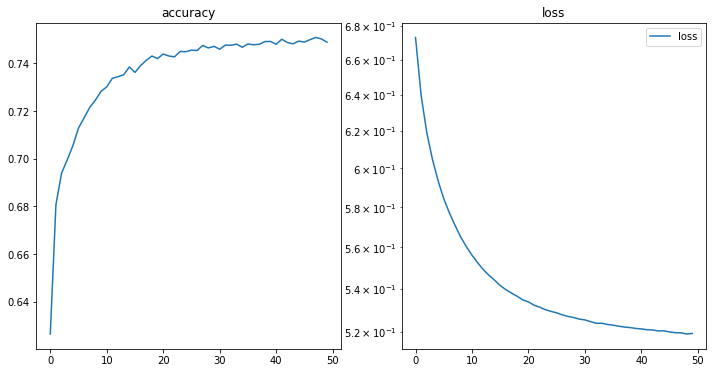

accuracy train for dims:  50 0.7486666666666667
accuracy dev for dims:  50 0.7498
accuracy dev_b for dims:  50 0.6815
epoch:  0  accuracy:  0.6258666666666667  loss:  0.66840994
epoch:  10  accuracy:  0.7560666666666667  loss:  0.5283264
epoch:  20  accuracy:  0.7706666666666666  loss:  0.49766764
epoch:  30  accuracy:  0.7743333333333333  loss:  0.48354778
epoch:  40  accuracy:  0.781  loss:  0.47555095


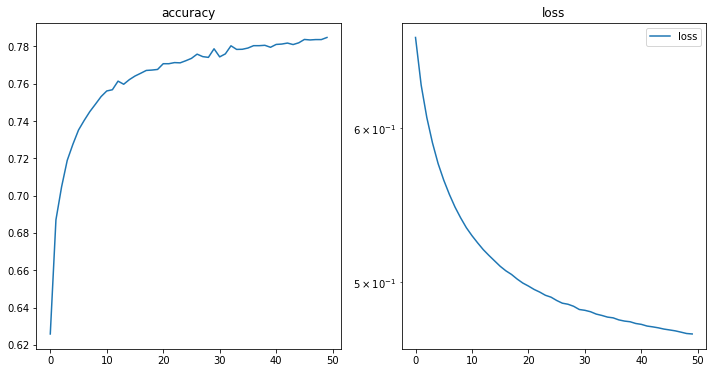

accuracy train for dims:  100 0.7851333333333333
accuracy dev for dims:  100 0.7814
accuracy dev_b for dims:  100 0.6985
epoch:  0  accuracy:  0.6586666666666667  loss:  0.654094
epoch:  10  accuracy:  0.7923333333333333  loss:  0.47704834
epoch:  20  accuracy:  0.8060666666666666  loss:  0.44212127
epoch:  30  accuracy:  0.8121333333333333  loss:  0.42601374
epoch:  40  accuracy:  0.8158000000000001  loss:  0.41697267


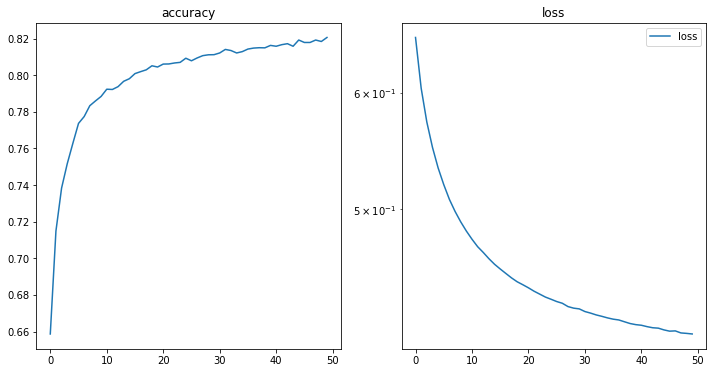

accuracy train for dims:  200 0.8196
accuracy dev for dims:  200 0.8175
accuracy dev_b for dims:  200 0.7435
epoch:  0  accuracy:  0.6742666666666667  loss:  0.64499605
epoch:  10  accuracy:  0.8128  loss:  0.44757986
epoch:  20  accuracy:  0.826  loss:  0.411085
epoch:  30  accuracy:  0.8318666666666666  loss:  0.395252
epoch:  40  accuracy:  0.8355333333333334  loss:  0.38623384


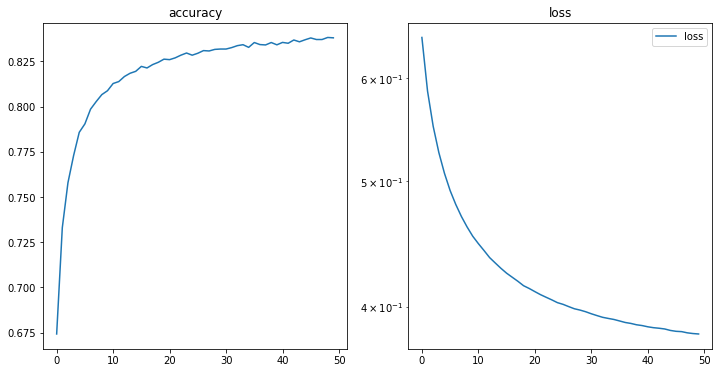

accuracy train for dims:  300 0.8382
accuracy dev for dims:  300 0.8334
accuracy dev_b for dims:  300 0.7525


In [0]:
vector_dims=[50,100,200,300]
predictions_train=[]
predictions_dev=[]
predictions_test=[]
predictions_dev_b=[]
predictions_test_b=[]


for size,i in zip(vector_dims, range(len(train_tensors))):
  model = LogisticRegressionBow(size, 2)#.cuda()
  optimizer = optim.Adam(model.parameters())
  loss_function = nn.CrossEntropyLoss()

  acc,losses=train(model,optimizer,loss_function,train_tensors[i],train_labels=train_labels,batch_size=50,epochs=50,accuracy_score=accuracy_score)


  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  plt.title('accuracy')
  plt.plot(acc,label='loss')
  plt.subplot(122)
  plt.semilogy(losses,label='loss')
  plt.title('loss')
  plt.legend()
  plt.show()

  preds_train=prediction(model,train_tensors[i],20)
  preds_dev=prediction(model,dev_tensors[i],20)
  preds_dev_b=prediction(model,dev_b_tensors[i],20)
  preds_test=prediction(model,test_tensors[i],20)
  preds_test_b=prediction(model,test_b_tensors[i],20)
  print('accuracy train for dims: ', size,accuracy_score(preds_train,train_labels))
  print('accuracy dev for dims: ',size,accuracy_score(preds_dev,dev_labels))
  print('accuracy dev_b for dims: ',size,accuracy_score(preds_dev_b,dev_labels_b))
  predictions_train.append(preds_train)
  predictions_dev.append(preds_dev)
  predictions_test.append(preds_test)
  predictions_dev_b.append(preds_dev_b)
  predictions_test_b.append(preds_test_b)

#### Now we can see that embedding dim=300 is best, now lets try to tune the model with different lr.

epoch:  0  accuracy:  0.7740666666666667  loss:  0.48348877
epoch:  10  accuracy:  0.8199333333333333  loss:  0.41318747
epoch:  20  accuracy:  0.8274000000000001  loss:  0.40353814
epoch:  30  accuracy:  0.8251333333333332  loss:  0.40971968
epoch:  40  accuracy:  0.8277333333333333  loss:  0.39799404


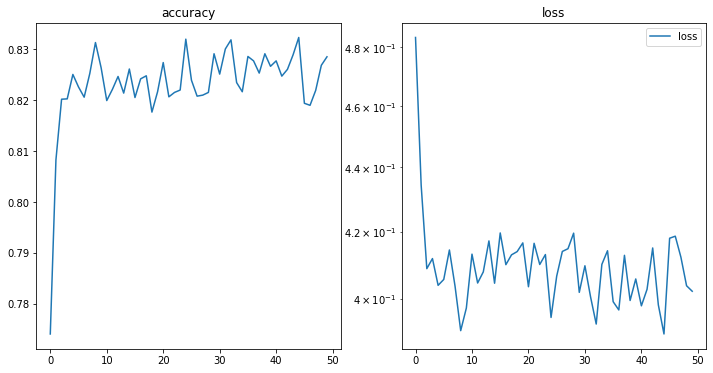

accuracy train:  0.8465333333333334
accuracy dev:  0.8328
accuracy dev_b:  0.7425
epoch:  0  accuracy:  0.7602666666666668  loss:  0.52411175
epoch:  10  accuracy:  0.8404666666666668  loss:  0.37474376
epoch:  20  accuracy:  0.8414  loss:  0.36879015
epoch:  30  accuracy:  0.8414  loss:  0.36593956
epoch:  40  accuracy:  0.8458666666666668  loss:  0.3670729


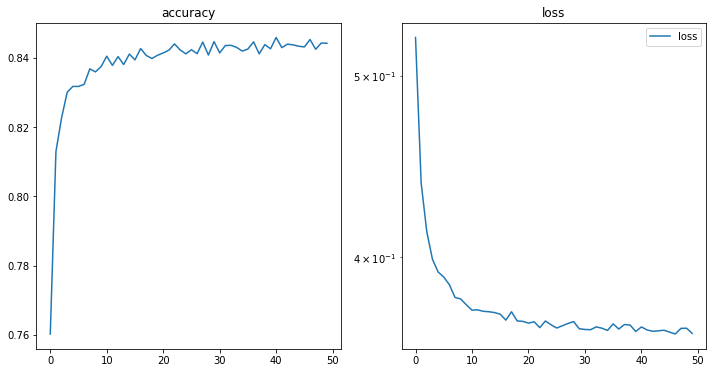

accuracy train:  0.847
accuracy dev:  0.8333
accuracy dev_b:  0.7435
epoch:  0  accuracy:  0.6785333333333333  loss:  0.64521027
epoch:  10  accuracy:  0.8106666666666668  loss:  0.446646
epoch:  20  accuracy:  0.828  loss:  0.41094595
epoch:  30  accuracy:  0.8334666666666667  loss:  0.39478034
epoch:  40  accuracy:  0.8368000000000001  loss:  0.3860252


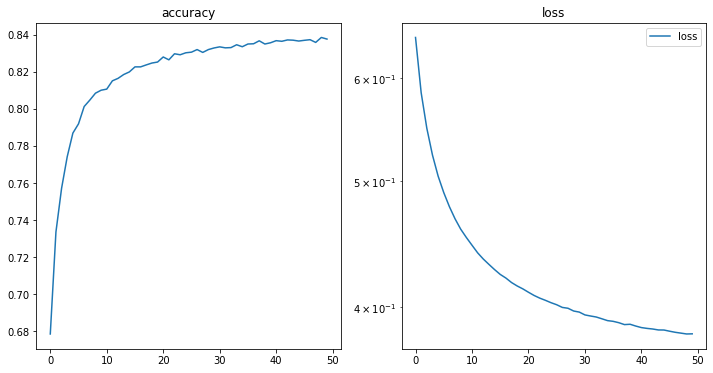

accuracy train:  0.839
accuracy dev:  0.8336
accuracy dev_b:  0.752
epoch:  0  accuracy:  0.5911333333333334  loss:  0.68846893
epoch:  10  accuracy:  0.7276666666666667  loss:  0.6046142
epoch:  20  accuracy:  0.7542  loss:  0.56028974
epoch:  30  accuracy:  0.7728666666666667  loss:  0.52988696
epoch:  40  accuracy:  0.7855333333333333  loss:  0.5077006


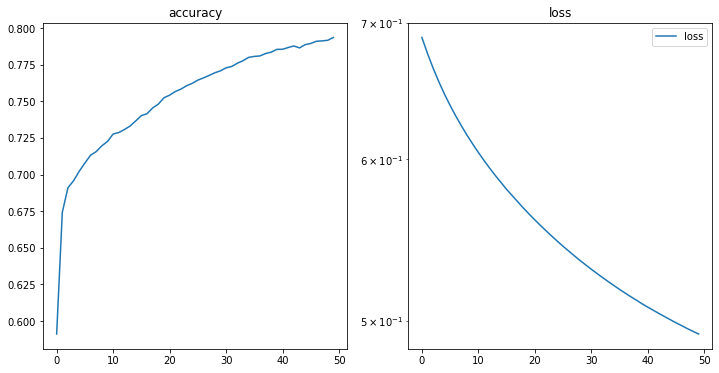

accuracy train:  0.7936666666666666
accuracy dev:  0.7924
accuracy dev_b:  0.723
epoch:  0  accuracy:  0.49866666666666665  loss:  0.70770305
epoch:  10  accuracy:  0.6794  loss:  0.6815609
epoch:  20  accuracy:  0.6951333333333332  loss:  0.6696271
epoch:  30  accuracy:  0.6988  loss:  0.65878165
epoch:  40  accuracy:  0.7055333333333332  loss:  0.64899546


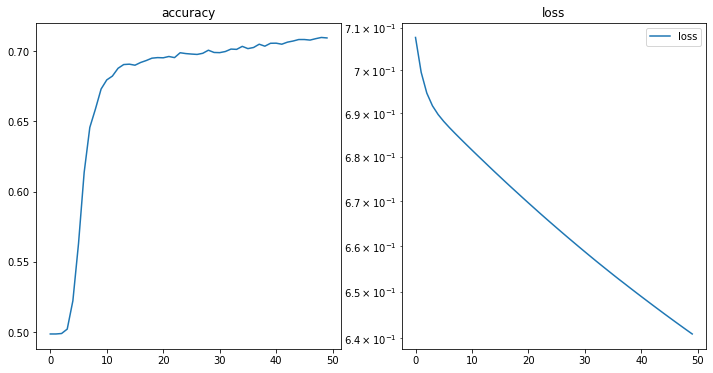

accuracy train:  0.71
accuracy dev:  0.7059
accuracy dev_b:  0.662


In [0]:
rates=[1e-1,1e-2,1e-3,1e-4,1e-5]

predictions_train=[]
predictions_dev=[]
predictions_test=[]
predictions_dev_b=[]
predictions_test_b=[]

for rate in rates:
  model = LogisticRegressionBow(300, 2)#.cuda()
  optimizer = optim.Adam(model.parameters(),lr=rate)
  loss_function = nn.CrossEntropyLoss()
  acc,losses=train(model,optimizer,loss_function,train_tensors[-1],train_labels=train_labels,batch_size=50,epochs=50,accuracy_score=accuracy_score)


  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  plt.title('accuracy')
  plt.plot(acc,label='loss')
  plt.subplot(122)
  plt.semilogy(losses,label='loss')
  plt.title('loss')
  plt.legend()
  plt.show()

  preds_train=prediction(model,train_tensors[-1],50)
  preds_dev=prediction(model,dev_tensors[-1],50)
  preds_dev_b=prediction(model,dev_b_tensors[-1],50)
  preds_test=prediction(model,test_tensors[-1],50)
  preds_test_b=prediction(model,test_b_tensors[-1],50)
  print('accuracy train: ',accuracy_score(preds_train,train_labels))
  print('accuracy dev: ',accuracy_score(preds_dev,dev_labels))
  print('accuracy dev_b: ',accuracy_score(preds_dev_b,dev_labels_b))
  predictions_train.append(preds_train)
  predictions_dev.append(preds_dev)
  predictions_test.append(preds_test)
  predictions_dev_b.append(preds_dev_b)
  predictions_test_b.append(preds_test_b)

# Finally lets train more epochs with Best hyperparams dim=300, lr=1e-3

In [0]:
from sklearn.metrics import accuracy_score

epoch:  0  accuracy:  0.6802666666666667  loss:  0.6434098
epoch:  10  accuracy:  0.8119999999999999  loss:  0.44620436
epoch:  20  accuracy:  0.8274666666666667  loss:  0.41051075
epoch:  30  accuracy:  0.8328  loss:  0.39488515
epoch:  40  accuracy:  0.835  loss:  0.38660094
epoch:  50  accuracy:  0.8379333333333334  loss:  0.3811567
epoch:  60  accuracy:  0.8390666666666667  loss:  0.37694892
epoch:  70  accuracy:  0.8401333333333334  loss:  0.37407285
epoch:  80  accuracy:  0.8419333333333334  loss:  0.37194747
epoch:  90  accuracy:  0.8426666666666667  loss:  0.37021285
epoch:  100  accuracy:  0.8422  loss:  0.3689472
epoch:  110  accuracy:  0.8438666666666667  loss:  0.36820653
epoch:  120  accuracy:  0.8438666666666668  loss:  0.36676356
epoch:  130  accuracy:  0.8445333333333332  loss:  0.3659515
epoch:  140  accuracy:  0.8439333333333333  loss:  0.36551586
epoch:  150  accuracy:  0.8450666666666667  loss:  0.3650322
epoch:  160  accuracy:  0.8452000000000001  loss:  0.36410558

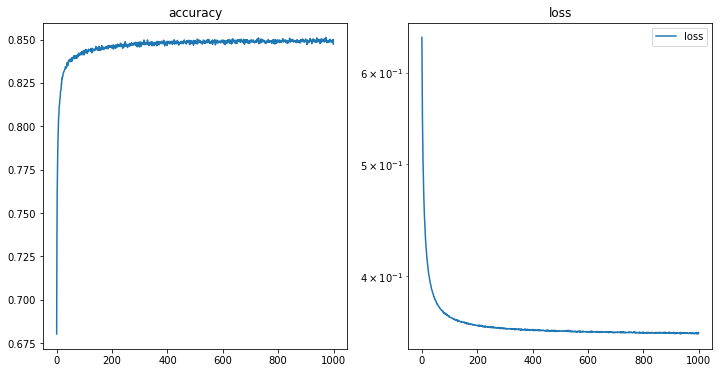

accuracy train:  0.8468
accuracy dev:  0.8336
accuracy dev_b:  0.7495


In [14]:
from classifier_word_embeddings import train
model = LogisticRegressionBow(300, 2)#.cuda()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
loss_function = nn.CrossEntropyLoss()
acc,losses=train(model,optimizer,loss_function,train_tensors[-1],train_labels=train_labels,batch_size=50,epochs=1000,accuracy_score=accuracy_score)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('accuracy')
plt.plot(acc,label='loss')
plt.subplot(122)
plt.semilogy(losses,label='loss')
plt.title('loss')
plt.legend()
plt.show()

preds_train=prediction(model,train_tensors[-1],50)
preds_dev=prediction(model,dev_tensors[-1],50)
preds_dev_b=prediction(model,dev_b_tensors[-1],50)
preds_test=prediction(model,test_tensors[-1],50)
preds_test_b=prediction(model,test_b_tensors[-1],50)
print('accuracy train: ',accuracy_score(preds_train,train_labels))
print('accuracy dev: ',accuracy_score(preds_dev,dev_labels))
print('accuracy dev_b: ',accuracy_score(preds_dev_b,dev_labels_b))

In [16]:
a=np.array([0,1,0,1,0,1,1,1,0])
a=pd.Series(a)
a.replace([0,1],['neg','pos'])

0    neg
1    pos
2    neg
3    pos
4    neg
5    pos
6    pos
7    pos
8    neg
dtype: object

In [0]:
def to_df(predictions):    
    dataframes=[]
    tokens=[train_tokens,dev_tokens,test_tokens,dev_b_tokens,test_b_tokens]
    names=['train/','dev/','test/','dev-b/','test-b/']
    for token,name,pred in tqdm(zip(tokens,names,predictions)):
        first_column=[]
        for i in range(len(token)):
            first_column.append(name+str(i))
        df = pd.DataFrame([first_column,pred]).T
        dataframes.append(df)
    result=pd.concat(dataframes,ignore_index=True) 
    result[1]=result[1].replace([0,1],['neg','pos'])
    return result
preds=[preds_train,preds_dev,preds_test,preds_dev_b,preds_test_b]

result=to_df(preds)
result.to_csv('file_ll.tsv',index=False,header=False,sep='\t')

5it [00:04,  1.19it/s]


### 2.2 Use word embeddings for text classification - FFNN

Use the same pre-trained word embeddings, but use instead of Logistic Regression a feedforward neural network. For both logistic regression and FFNN model, perform tuning of meta-parameters, such as the learning rate.

## FFNN

In [0]:
#load model 
from classifier_word_embeddings import Feedforward
from classifier_word_embeddings import train_NN
from classifier_word_embeddings import prediction_nn

In [4]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.tanh = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 10)
            self.tanh1 = torch.nn.ReLU()
            self.fc3=torch.nn.Linear(10,1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            tanh = self.tanh(hidden)

            output = self.fc2(tanh)
            output = self.tanh1(output)

            output = self.fc3(output)
            output = self.sigmoid(output)
            return output

In [5]:
text,labels=train_text,train_labels
batch_size=50
preprocessed_train = preprocess_text(text,True,False)
train_tokens=tokenization(preprocessed_train)

labels=labels[0].replace(['neg','pos'],[0,1])
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

train_doc_vecs=vector(train_tokens,glove_model_300)
train_tensors=tensor_from_array(train_doc_vecs) 

train_loader=dataLoader(train_tensors,labels,batch_size)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:48<00:00, 316.68it/s]


In [6]:
model = Feedforward(300, 50)#.cuda()
optimizer = optim.Adam(model.parameters())
loss_function = nn.BCEWithLogitsLoss()

In [46]:
def train_NN(text,labels):
  preprocessed_train = preprocess_text(text,True,False)
  train_tokens=tokenization(preprocessed_train)

  labels=labels[0].replace(['neg','pos'],[0,1])
  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs) 

  train_loader=dataLoader(train_tensors,labels,batch_size)  
  model = Feedforward(300, 50)#.cuda()
  optimizer = optim.Adam(model.parameters())
  loss_function = nn.BCEWithLogitsLoss()
  loader=dataLoader(train_tensors,labels,batch_size)
  train_losses=[]
  train_accuracy=[]
  for epoch in range((20)):
    model.train(True)
    loss_epoch=[]
    accuracy_epoch=[]
    for x_batch,y_batch in (loader):

      prediction=model(x_batch)

      loss=loss_function(prediction.view(-1),y_batch)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_epoch.append(loss.data.cpu().numpy())

      accuracy_epoch.append(accuracy_score(prediction.detach().cpu().numpy().round(),y_batch.detach().cpu().numpy()))

    model.train(False)
    train_losses.append(np.mean(loss_epoch))
    train_accuracy.append(np.mean(accuracy_epoch))
    if epoch%10==0:
        print('epoch: ',epoch,' accuracy: ',train_accuracy[-1],' loss: ', train_losses[-1])
  return model
    

In [9]:
train_labels1=train_labels[0].replace(['neg','pos'],[0,1])

In [47]:
model=train_NN(train_text,train_labels)
preds_train=classify(train_text,model)
accuracy_score(preds_train,train_labels)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:44<00:00, 338.13it/s]


epoch:  0  accuracy:  0.5021333333333334  loss:  0.691882
epoch:  10  accuracy:  0.8296  loss:  0.5796722


In [55]:
def classify(text,model):
  preprocessed_train = preprocess_text(text,True,False)
  train_tokens=tokenization(preprocessed_train)

  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs) 

  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in train_tensors])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=50,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred=np.concatenate(preds).reshape(-1)
  y_pred=pd.Series(y_pred)
  y_pred=y_pred.replace([0,1],['neg','pos'])  
    
  return y_pred
preds_train=classify(train_text,model)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:40<00:00, 367.05it/s]


In [56]:
accuracy_score(preds_train,train_labels)

0.8298666666666666

In [85]:
def train(text,labels):
    batch_size=50
    preprocessed_train = preprocess_text(text,True,False)
    train_tokens=tokenization(preprocessed_train)
    
    labels=labels[0].replace(['neg','pos'],[0,1])
    glove_input_file = 'glove.6B.300d.txt'
    word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
    glove2word2vec(glove_input_file, word2vec_output_file)
    glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)
    
    train_doc_vecs=vector(train_tokens,glove_model_300)
    train_tensors=tensor_from_array(train_doc_vecs) 
    
    train_loader=dataLoader(train_tensors,labels,batch_size)
    model = Feedforward(300, 50)#.cuda()
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    loss_function = nn.BCEWithLogitsLoss()
    for epoch in tqdm(range(10)):
        model.train(True)
        loss_epoch=[]
        accuracy_epoch=[]
        for x_batch,y_batch in (loader):

          prediction=model(x_batch)

          loss=loss_function(prediction.view(-1),y_batch)

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

        model.train(False)

    return model

In [86]:
model=train(train_text,train_labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.50s/it]


In [87]:
def classify(data,model):
  batchsize=50 
  preprocessed_train = preprocess_text(data,True,False)
  train_tokens=tokenization(preprocessed_train)
  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs)  

  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in train_tensors])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred=np.concatenate(preds)
  y_pred=pd.Series(y_pred)
  y_pred.replace([0,1],['neg','pos'])
  return y_pred

In [88]:
y_pred=classify(train_text,model)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:45<00:00, 328.94it/s]


Exception: Data must be 1-dimensional

In [ ]:
y_pred

In [ ]:
def prediction_nn(model,data,batchsize):
  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in data])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred=np.concatenate(preds)
  return y_pred
preds_train=prediction_nn(model,train_tensors,50)

In [ ]:
text,labels=train_text,train_labels
batch_size=50
preprocessed_train = preprocess_text(text,True,False)
train_tokens=tokenization(preprocessed_train)

labels=labels[0].replace(['neg','pos'],[0,1])
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

train_doc_vecs=vector(train_tokens,glove_model_300)
train_tensors=tensor_from_array(train_doc_vecs) 

train_loader=dataLoader(train_tensors,labels,batch_size)
model = Feedforward(300, 50)#.cuda()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
loss_function = nn.BCEWithLogitsLoss()
for epoch in tqdm(range(10)):
    model.train(True)
    for X,y in (train_loader):

    #             y=y.type(torch.LongTensor)

        l_probs = model(X)

        loss=loss_function(l_probs.view(-1),y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    model.train(False)  

In [57]:
acc=[]
loader=dataLoader(train_tensors,labels,batch_size)
model = Feedforward(300, 50)#.cuda()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
loss_function = nn.BCEWithLogitsLoss()
for epoch in range((10)):
    model.train(True)
    loss_epoch=[]
    accuracy_epoch=[]
    for x_batch,y_batch in (loader):
        prediction=model(x_batch)
        loss=loss_function(prediction.view(-1),y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_epoch.append(loss.data.cpu().numpy())
        accuracy_epoch.append(accuracy_score(prediction.detach().cpu().numpy().round(),y_batch.detach().cpu().numpy()))

    model.train(False)
    acc.append(np.mean(loss_epoch))


In [58]:
acc

[0.6888774,
 0.63148254,
 0.60484254,
 0.5957966,
 0.5912626,
 0.58808196,
 0.5855881,
 0.58413106,
 0.5829008,
 0.5816734]

In [ ]:
def prediction(model,data,batchsize):
  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in data])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred=np.concatenate(preds)
  return y_pred

In [78]:
preds=[]
model.eval()
tensor_set=torch.stack([torch.Tensor(i) for i in train_tensors])
data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
loader=data_utils.DataLoader(data_set,batch_size=50,shuffle=False)

for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
y_pred=np.concatenate(preds)

In [79]:
y_pred=pd.Series(y_pred_)
y_pred.replace([0,1],['neg','pos'])

0        neg
1        neg
2        neg
3        neg
4        neg
5        neg
6        neg
7        neg
8        neg
9        neg
10       neg
11       neg
12       neg
13       neg
14       neg
15       neg
16       neg
17       neg
18       neg
19       neg
20       neg
21       neg
22       neg
23       neg
24       neg
25       neg
26       neg
27       neg
28       neg
29       neg
        ... 
14970    neg
14971    neg
14972    neg
14973    neg
14974    neg
14975    neg
14976    neg
14977    neg
14978    neg
14979    neg
14980    neg
14981    neg
14982    neg
14983    neg
14984    neg
14985    neg
14986    neg
14987    neg
14988    neg
14989    neg
14990    neg
14991    neg
14992    neg
14993    neg
14994    neg
14995    neg
14996    neg
14997    neg
14998    neg
14999    neg
Length: 15000, dtype: object

In [11]:
def train(text,labels):
    batch_size=50
    preprocessed_train = preprocess_text(text,True,False)
    train_tokens=tokenization(preprocessed_train)
    
    labels=labels[0].replace(['neg','pos'],[0,1])
    glove_input_file = 'glove.6B.300d.txt'
    word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
    glove2word2vec(glove_input_file, word2vec_output_file)
    glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)
    
    train_doc_vecs=vector(train_tokens,glove_model_300)
    train_tensors=tensor_from_array(train_doc_vecs) 
    
    train_loader=dataLoader(train_tensors,labels,batch_size)
    model = Feedforward(300, 50)#.cuda()
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    loss_function = nn.BCEWithLogitsLoss()
    for epoch in tqdm(range(10)):
        model.train(True)
        for X,y in (train_loader):
      
#             y=y.type(torch.LongTensor)
            
            l_probs = model(X)

            loss=loss_function(l_probs.view(-1),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.train(False)       

    return model

In [59]:
def train_NN(model,optimizer,loss_function,train_tensors,train_labels,batch_size,epochs,accuracy_score):
  loader=dataLoader(train_tensors,train_labels,batch_size)

  for epoch in range((epochs)):
    model.train(True)
    loss_epoch=[]
    accuracy_epoch=[]
    for x_batch,y_batch in (loader):

      prediction=model(x_batch)

      loss=loss_function(prediction.view(-1),y_batch)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_epoch.append(loss.data.cpu().numpy())

      accuracy_epoch.append(accuracy_score(prediction.detach().cpu().numpy().round(),y_batch.detach().cpu().numpy()))

    model.train(False)
    train_losses.append(np.mean(loss_epoch))
    train_accuracy.append(np.mean(accuracy_epoch))
    if epoch%10==0:
        print('epoch: ',epoch,' accuracy: ',train_accuracy[-1],' loss: ', train_losses[-1])
  return train_accuracy,train_losses

In [12]:
def classify(data,model):
  batchsize=50 
  preprocessed_train = preprocess_text(data,True,False)
  train_tokens=tokenization(preprocessed_train)
  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs)  

  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in train_tensors])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred_=np.concatenate(preds)
  y_pred=pd.Series(y_pred_)
  y_pred.replace([0,1],['neg','pos'])
  return y_pred_,y_pred

In [13]:
model=train(train_text,train_labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


In [14]:
y_pred_,y_pred=classify(train_text,model)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:45<00:00, 326.47it/s]


Exception: Data must be 1-dimensional

In [ ]:
train_labels_1=train_labels[0].replace(['neg','pos'],[0,1])
accuracy_score(y_pred_,train_labels_1)

In [8]:
def classify(data,model):
  batchsize=50 
  preprocessed_train = preprocess_text(data,True,False)
  train_tokens=tokenization(preprocessed_train)
  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'glove.6B.300d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
  glove_model_300 = KeyedVectors.load_word2vec_format("glove.6B.300d.w2vformat.txt", binary=False)

  train_doc_vecs=vector(train_tokens,glove_model_300)
  train_tensors=tensor_from_array(train_doc_vecs)  

  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in train_tensors])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(np.argmax(predictions.detach().numpy(),axis=1))
  y_pred_=np.concatenate(preds)
  y_pred=pd.Series(y_pred_)
  y_pred.replace([0,1],['neg','pos'])
  return y_pred_,y_pred

In [ ]:
def prediction(model,data,batchsize):
  preds=[]
  model.eval()
  tensor_set=torch.stack([torch.Tensor(i) for i in data])
  data_set=data_utils.TensorDataset(tensor_set,torch.zeros(tensor_set.shape[0]),)
  loader=data_utils.DataLoader(data_set,batch_size=batchsize,shuffle=False)
  
  for test_batch,y in loader:
    predictions = model(test_batch)
    preds.append(predictions.detach().numpy().round())
  y_pred=np.concatenate(preds)
  return y_pred

In [65]:
def train_NN(model,optimizer,loss_function,train_tensors,train_labels,batch_size,epochs,accuracy_score):
  loader=dataLoader(train_tensors,train_labels,batch_size)
  train_losses=[] 
  train_accuracy=[]  
  for epoch in range((epochs)):
    model.train(True)
    loss_epoch=[]
    accuracy_epoch=[]
    for x_batch,y_batch in (loader):

      prediction=model(x_batch)

      loss=loss_function(prediction.view(-1),y_batch)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_epoch.append(loss.data.cpu().numpy())

      accuracy_epoch.append(accuracy_score(prediction.detach().cpu().numpy().round(),y_batch.detach().cpu().numpy()))

    model.train(False)
    train_losses.append(np.mean(loss_epoch))
    train_accuracy.append(np.mean(accuracy_epoch))
    if epoch%10==0:
        print('epoch: ',epoch,' accuracy: ',train_accuracy[-1],' loss: ', train_losses[-1])
  return train_accuracy,train_losses

epoch:  0  accuracy:  0.49946666666666667  loss:  0.6959338
epoch:  10  accuracy:  0.7336  loss:  0.62052864
epoch:  20  accuracy:  0.7408  loss:  0.61718696
epoch:  30  accuracy:  0.7418  loss:  0.6160294
epoch:  40  accuracy:  0.7460666666666667  loss:  0.61469686
epoch:  50  accuracy:  0.746  loss:  0.6143468
epoch:  60  accuracy:  0.7499333333333333  loss:  0.61322683
epoch:  70  accuracy:  0.7489333333333333  loss:  0.6127528
epoch:  80  accuracy:  0.754  loss:  0.6112789
epoch:  90  accuracy:  0.7574666666666667  loss:  0.61086744
epoch:  100  accuracy:  0.7567333333333333  loss:  0.6104997
epoch:  110  accuracy:  0.7568  loss:  0.61080486
epoch:  120  accuracy:  0.7633333333333334  loss:  0.6088781
epoch:  130  accuracy:  0.7616  loss:  0.60857
epoch:  140  accuracy:  0.7623333333333333  loss:  0.6077289
epoch:  150  accuracy:  0.7617999999999999  loss:  0.60815793
epoch:  160  accuracy:  0.7667333333333333  loss:  0.6066978
epoch:  170  accuracy:  0.7666000000000001  loss:  0.6

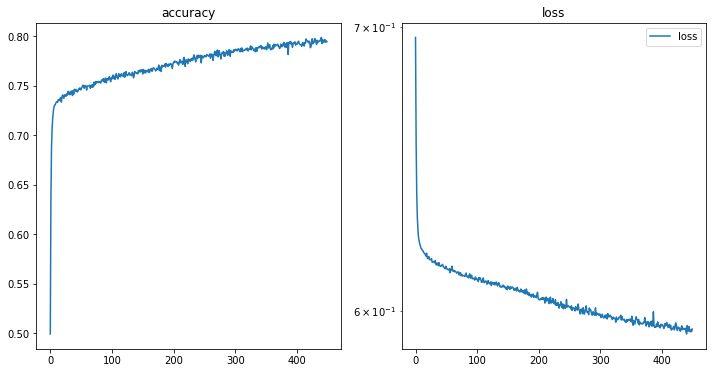

accuracy train for dims:  50 0.8001333333333334
accuracy dev for dims:  50 0.7531
accuracy dev_b for dims:  50 0.6805
epoch:  0  accuracy:  0.5022666666666666  loss:  0.6930288
epoch:  10  accuracy:  0.7672666666666667  loss:  0.6055523
epoch:  20  accuracy:  0.776  loss:  0.60198414
epoch:  30  accuracy:  0.7814666666666666  loss:  0.59953386
epoch:  40  accuracy:  0.785  loss:  0.59843016
epoch:  50  accuracy:  0.7807999999999999  loss:  0.59996885
epoch:  60  accuracy:  0.7858  loss:  0.5978696
epoch:  70  accuracy:  0.7872  loss:  0.5965568
epoch:  80  accuracy:  0.7898666666666668  loss:  0.59643495
epoch:  90  accuracy:  0.7901333333333334  loss:  0.595486
epoch:  100  accuracy:  0.7877333333333333  loss:  0.5961784
epoch:  110  accuracy:  0.7901999999999999  loss:  0.5960963
epoch:  120  accuracy:  0.7955333333333334  loss:  0.59419745
epoch:  130  accuracy:  0.7899333333333334  loss:  0.5962691
epoch:  140  accuracy:  0.7940666666666668  loss:  0.5946244
epoch:  150  accuracy: 

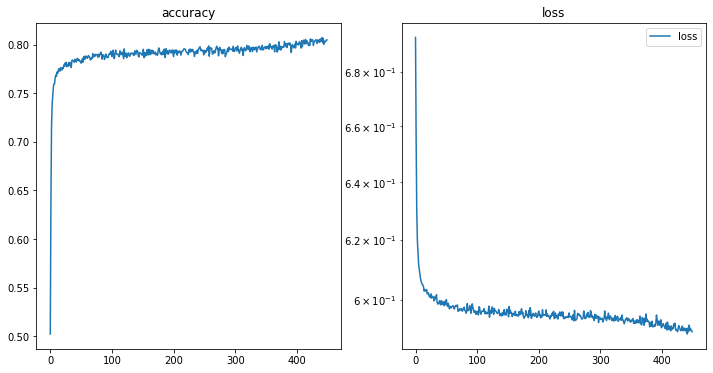

accuracy train for dims:  100 0.8119333333333333
accuracy dev for dims:  100 0.788
accuracy dev_b for dims:  100 0.7025
epoch:  0  accuracy:  0.4988666666666667  loss:  0.6959275
epoch:  10  accuracy:  0.8055333333333333  loss:  0.5903568
epoch:  20  accuracy:  0.8161333333333333  loss:  0.5850844
epoch:  30  accuracy:  0.8209333333333333  loss:  0.58298993
epoch:  40  accuracy:  0.8198666666666666  loss:  0.582674
epoch:  50  accuracy:  0.8255333333333335  loss:  0.5809479
epoch:  60  accuracy:  0.8256  loss:  0.5810222
epoch:  70  accuracy:  0.8268666666666669  loss:  0.5802049
epoch:  80  accuracy:  0.8266666666666667  loss:  0.58062166
epoch:  90  accuracy:  0.8274  loss:  0.57934105
epoch:  100  accuracy:  0.8316666666666668  loss:  0.57771915
epoch:  110  accuracy:  0.8300666666666668  loss:  0.578544
epoch:  120  accuracy:  0.8309333333333333  loss:  0.5780795
epoch:  130  accuracy:  0.8312  loss:  0.5782917
epoch:  140  accuracy:  0.8353333333333333  loss:  0.5768528
epoch:  15

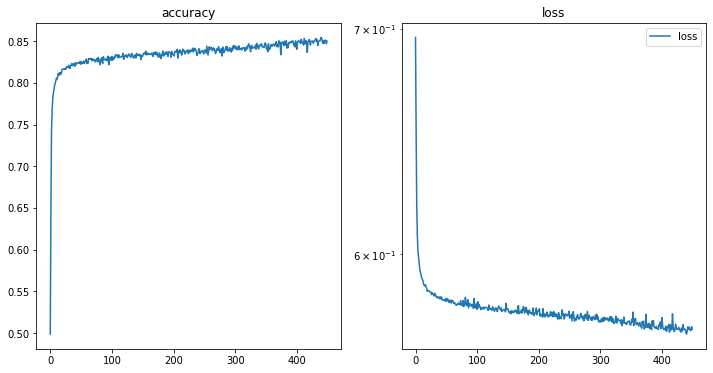

accuracy train for dims:  200 0.8354
accuracy dev for dims:  200 0.8053
accuracy dev_b for dims:  200 0.7425
epoch:  0  accuracy:  0.5085333333333334  loss:  0.69062054
epoch:  10  accuracy:  0.8294000000000001  loss:  0.5808198
epoch:  20  accuracy:  0.8348000000000001  loss:  0.57730675
epoch:  30  accuracy:  0.8397333333333333  loss:  0.57510144
epoch:  40  accuracy:  0.8422666666666667  loss:  0.57359946
epoch:  50  accuracy:  0.8434666666666666  loss:  0.573731
epoch:  60  accuracy:  0.8467333333333334  loss:  0.57205
epoch:  70  accuracy:  0.8471333333333333  loss:  0.5720671
epoch:  80  accuracy:  0.8474  loss:  0.5718234
epoch:  90  accuracy:  0.8509333333333333  loss:  0.56972736
epoch:  100  accuracy:  0.8528666666666667  loss:  0.56913716
epoch:  110  accuracy:  0.8538666666666666  loss:  0.5694028
epoch:  120  accuracy:  0.8549333333333334  loss:  0.56822914
epoch:  130  accuracy:  0.8570666666666666  loss:  0.5676268
epoch:  140  accuracy:  0.8602  loss:  0.5661188
epoch: 

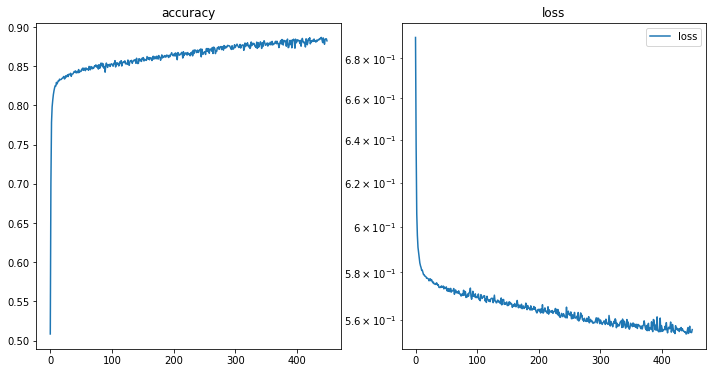

accuracy train for dims:  300 0.8882
accuracy dev for dims:  300 0.8305
accuracy dev_b for dims:  300 0.7505


In [0]:
vector_dims=[50,100,200,300]
predictions_train_nn=[]
predictions_dev_nn=[]
predictions_test_nn=[]
predictions_dev_b_nn=[]
predictions_test_b_nn=[]


for size,i in zip(vector_dims, range(len(train_tensors))):
  model = Feedforward(size, 50)#.cuda()
  optimizer = optim.Adam(model.parameters())
  loss_function = nn.BCEWithLogitsLoss()

  acc,losses=train_NN(model,optimizer,loss_function,train_tensors[i],train_labels=train_labels,batch_size=50,epochs=450,accuracy_score=accuracy_score)

  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  plt.title('accuracy')
  plt.plot(acc,label='loss')
  plt.subplot(122)
  plt.semilogy(losses,label='loss')
  plt.title('loss')
  plt.legend()
  plt.show()

  preds_train=prediction_nn(model,train_tensors[i],50)
  preds_dev=prediction_nn(model,dev_tensors[i],50)
  preds_dev_b=prediction_nn(model,dev_b_tensors[i],50)
  preds_test=prediction_nn(model,test_tensors[i],50)
  preds_test_b=prediction_nn(model,test_b_tensors[i],50)
  print('accuracy train for dims: ', size,accuracy_score(preds_train,train_labels))
  print('accuracy dev for dims: ',size,accuracy_score(preds_dev,dev_labels))
  print('accuracy dev_b for dims: ',size,accuracy_score(preds_dev_b,dev_labels_b))
  predictions_train_nn.append(preds_train)
  predictions_dev_nn.append(preds_dev)
  predictions_test_nn.append(preds_test)
  predictions_dev_b_nn.append(preds_dev_b)
  predictions_test_b_nn.append(preds_test_b)

### as we can see for FFNN the embedding dim=300 is better too, now lets choose lr

In [62]:
train_labels1=train_labels[0].replace(['neg','pos'],[0,1])

epoch:  0  accuracy:  0.49866666666666665  loss:  0.6932167


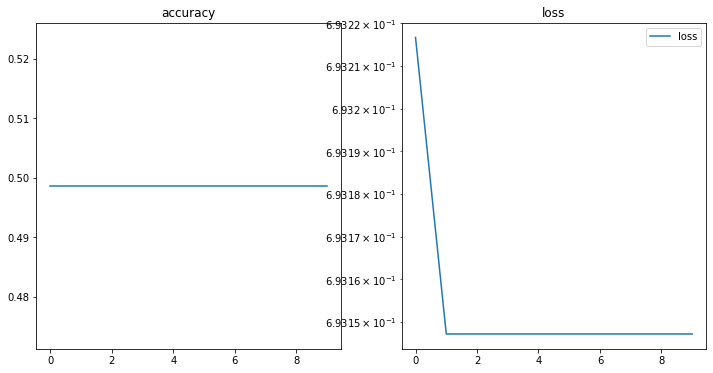

epoch:  0  accuracy:  0.6952666666666667  loss:  0.6317176


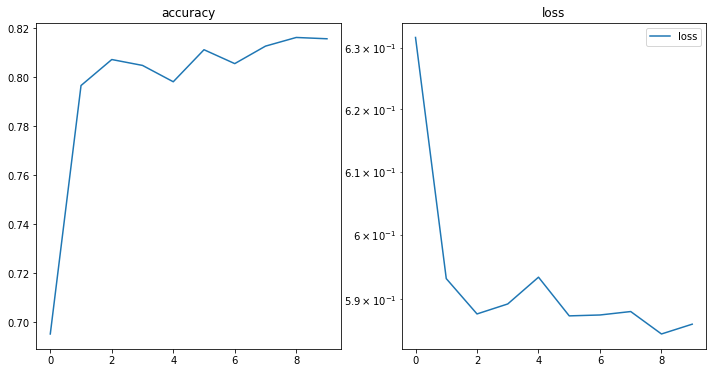

epoch:  0  accuracy:  0.5062  loss:  0.6919998


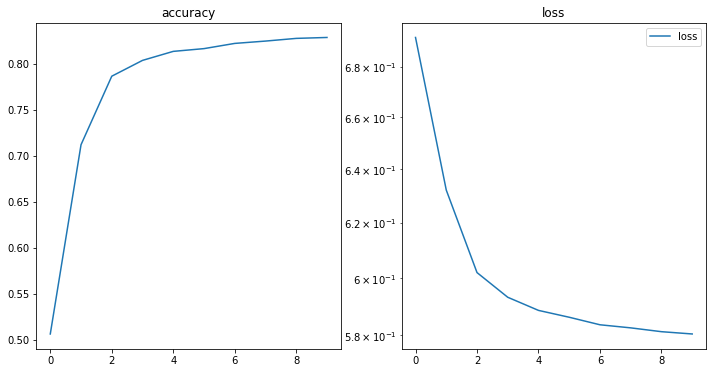

epoch:  0  accuracy:  0.5028  loss:  0.7176365


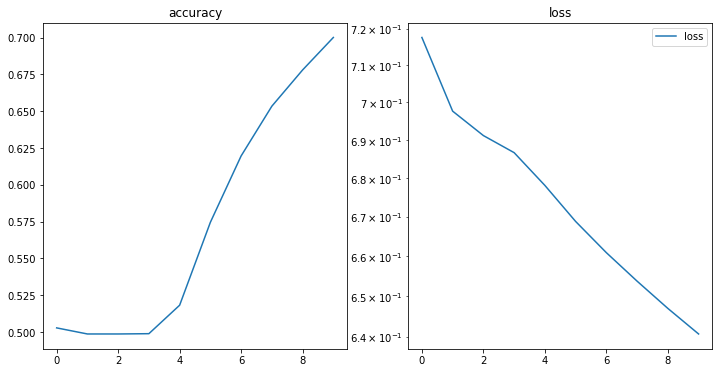

epoch:  0  accuracy:  0.5032666666666666  loss:  0.7226689


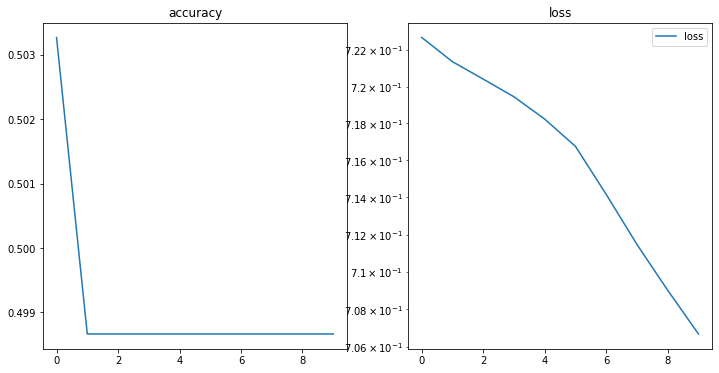

In [66]:
rates=[1e-1,1e-2,1e-3,1e-4,1e-5]
predictions_train_nn=[]
predictions_dev_nn=[]
predictions_test_nn=[]
predictions_dev_b_nn=[]
predictions_test_b_nn=[]


for rate in (rates):
  model = Feedforward(300, 50)#.cuda()
  optimizer = optim.Adam(model.parameters(),lr=rate)
  loss_function = nn.BCEWithLogitsLoss()

  acc,losses=train_NN(model,optimizer,loss_function,train_tensors,train_labels=train_labels1,batch_size=50,epochs=10,accuracy_score=accuracy_score)

  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  plt.title('accuracy')
  plt.plot(acc,label='loss')
  plt.subplot(122)
  plt.semilogy(losses,label='loss')
  plt.title('loss')
  plt.legend()
  plt.show()

#   preds_train=prediction_nn(model,train_tensors[-1],50)
#   preds_dev=prediction_nn(model,dev_tensors[-1],50)
#   preds_dev_b=prediction_nn(model,dev_b_tensors[-1],50)
#   preds_test=prediction_nn(model,test_tensors[-1],50)
#   preds_test_b=prediction_nn(model,test_b_tensors[-1],50)
#   print('accuracy train: ', accuracy_score(preds_train,train_labels))
#   print('accuracy dev: ',accuracy_score(preds_dev,dev_labels))
#   print('accuracy dev_b: ',accuracy_score(preds_dev_b,dev_labels_b))
#   predictions_train_nn.append(preds_train)
#   predictions_dev_nn.append(preds_dev)
#   predictions_test_nn.append(preds_test)
#   predictions_dev_b_nn.append(preds_dev_b)
#   predictions_test_b_nn.append(preds_test_b)

# Finally train FFNN with dim=300, lr=1e-3

epoch:  0  accuracy:  0.5556  loss:  0.67947567
epoch:  10  accuracy:  0.8282  loss:  0.58062863
epoch:  20  accuracy:  0.8356  loss:  0.5762901
epoch:  30  accuracy:  0.8399333333333334  loss:  0.57519984
epoch:  40  accuracy:  0.8412000000000001  loss:  0.57436395
epoch:  50  accuracy:  0.8401333333333333  loss:  0.5745106
epoch:  60  accuracy:  0.8438666666666668  loss:  0.57241184
epoch:  70  accuracy:  0.8430666666666667  loss:  0.5728739
epoch:  80  accuracy:  0.8441333333333334  loss:  0.57264066
epoch:  90  accuracy:  0.8452666666666667  loss:  0.5718614
epoch:  100  accuracy:  0.8493999999999999  loss:  0.5705572
epoch:  110  accuracy:  0.8490666666666665  loss:  0.57032275
epoch:  120  accuracy:  0.8495333333333333  loss:  0.571244
epoch:  130  accuracy:  0.8497333333333333  loss:  0.57044303
epoch:  140  accuracy:  0.8558666666666667  loss:  0.5677847
epoch:  150  accuracy:  0.8528666666666667  loss:  0.5691222
epoch:  160  accuracy:  0.8584000000000002  loss:  0.5669396
epo

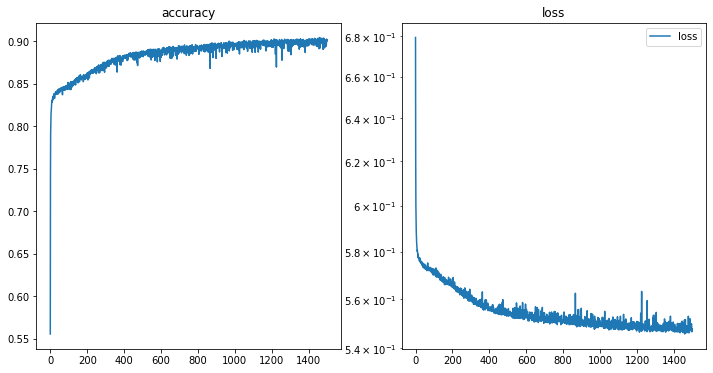

accuracy train:  0.9012666666666667
accuracy dev:  0.825
accuracy dev_b:  0.733


In [16]:
model = Feedforward(300, 50)#.cuda()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
loss_function = nn.BCEWithLogitsLoss()

acc,losses=train_NN(model,optimizer,loss_function,train_tensors[-1],train_labels=train_labels,batch_size=50,epochs=1500,accuracy_score=accuracy_score)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('accuracy')
plt.plot(acc,label='loss')
plt.subplot(122)
plt.semilogy(losses,label='loss')
plt.title('loss')
plt.legend()
plt.show()

preds_train=prediction_nn(model,train_tensors[-1],50)
preds_dev=prediction_nn(model,dev_tensors[-1],50)
preds_dev_b=prediction_nn(model,dev_b_tensors[-1],50)
preds_test=prediction_nn(model,test_tensors[-1],50)
preds_test_b=prediction_nn(model,test_b_tensors[-1],50)

print('accuracy train: ', accuracy_score(preds_train,train_labels))
print('accuracy dev: ',accuracy_score(preds_dev,dev_labels))
print('accuracy dev_b: ',accuracy_score(preds_dev_b,dev_labels_b))

In [0]:
def to_df(predictions):    
    dataframes=[]
    tokens=[train_tokens,dev_tokens,test_tokens,dev_b_tokens,test_b_tokens]
    names=['train/','dev/','test/','dev-b/','test-b/']
    for token,name,pred in tqdm(zip(tokens,names,predictions)):
        first_column=[]
        for i in range(len(token)):
            first_column.append(name+str(i))
        df = pd.DataFrame([first_column,pred]).T
        dataframes.append(df)
    result=pd.concat(dataframes,ignore_index=True) 
    result[1]=result[1].replace([0,1],['neg','pos'])
    return result
preds=[preds_train,preds_dev,preds_test,preds_dev_b,preds_test_b]

result=to_df(preds)
result.to_csv('file2_ff.tsv',index=False,header=False,sep='\t')

5it [00:04,  1.20it/s]


### 2.3 Use of document embeddings for text classification 

Use ``gensim`` to obtain document embeddings for all reviews. Build a model based on logistic regression using ``sklearn`` which load these embeddings for each document and performs a classification. 

### I will use embeddings dim=300

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
from sklearn.linear_model import LogisticRegression

def gensim_preprocess_tain(data,labels):
  train_documents = [TaggedDocument(gensim.utils.simple_preprocess(doc), [label]) for  doc,label in zip(data,labels)]
  return train_documents

def gensim_preprocess_test(data):
  preprocessed=[gensim.utils.simple_preprocess(sentence) for sentence in data]
  return preprocessed

model = Doc2Vec(vector_size=300, min_count=1, epochs=55)
from sklearn.metrics import accuracy_score
# from classifier_doc_embeddings import logreg

In [20]:

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# import gensim

In [21]:
from sklearn.linear_model import LogisticRegression

In [12]:
train_text=text_readers('FILIMDB/train.texts')
dev=text_readers('FILIMDB/dev.texts')
test=text_readers('FILIMDB/test.texts')
dev_b=text_readers('FILIMDB/dev-b.texts')
test_b=text_readers('FILIMDB/test-b.texts')


train_labels=pd.read_csv('FILIMDB/train.labels',header=None)
dev_labels=pd.read_csv('FILIMDB/dev.labels',header=None)
dev_labels_b=pd.read_csv('FILIMDB/dev-b.labels',header=None)


# train_labels=train_labels[0].replace(['neg','pos'],[0,1])
# dev_labels=dev_labels[0].replace(['neg','pos'],[0,1])
# dev_labels_b=dev_labels_b[0].replace(['neg','pos'],[0,1])

In [0]:
train_gensim_data=gensim_preprocess_tain(train,train_labels)
data_train=gensim_preprocess_test(train)
data_dev=gensim_preprocess_test(dev)
data_test=gensim_preprocess_test(test)
data_dev_b=gensim_preprocess_test(dev_b)
data_test_b=gensim_preprocess_test(test_b)

In [23]:
def vectors_creature(model,tokens_list:list):
  vectors=[model.infer_vector(sentence) for sentence in tqdm(tokens_list) ]
  return vectors
model = Doc2Vec(vector_size=300, min_count=1, epochs=55)

In [24]:
def train(text,labels):
    labels=labels[0].replace(['neg','pos'],[0,1])
    train_gensim_data=gensim_preprocess_tain(text,labels)
    data_train=gensim_preprocess_test(text)
    model.build_vocab(train_gensim_data)
    model.epochs=2
    model.train(train_gensim_data, total_examples=model.corpus_count, epochs=model.epochs) 
    vectors=vectors_creature(model,data_train)
    logreg = LogisticRegression(C=0.01,penalty='l2',max_iter=200,random_state=42,solver='saga')
    logreg.fit(vectors,train_labels)
    return logreg

In [25]:
logreg=train(train_text,train_labels)



  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

  0%|▏                                                                             | 39/15000 [00:00<00:38, 386.05it/s]

  0%|▎                                                                             | 69/15000 [00:00<00:42, 355.43it/s]

  1%|▍                                                                             | 94/15000 [00:00<00:47, 313.11it/s]

  1%|▌                                                                            | 121/15000 [00:00<00:50, 295.82it/s]

  1%|▋                                                                            | 145/15000 [00:00<00:54, 272.73it/s]

  1%|▉                                                                            | 175/15000 [00:00<00:53, 277.25it/s]

  1%|█                                                                            | 199/15000 [00:00<00:57, 258.89it/s]

  1%|█▏                       

 28%|█████████████████████▎                                                      | 4199/15000 [00:14<00:31, 339.39it/s]

 28%|█████████████████████▍                                                      | 4234/15000 [00:14<00:32, 335.44it/s]

 28%|█████████████████████▌                                                      | 4268/15000 [00:14<00:35, 301.90it/s]

 29%|█████████████████████▊                                                      | 4299/15000 [00:14<00:35, 300.72it/s]

 29%|█████████████████████▉                                                      | 4330/15000 [00:14<00:36, 293.93it/s]

 29%|██████████████████████▏                                                     | 4368/15000 [00:15<00:33, 314.54it/s]

 29%|██████████████████████▎                                                     | 4401/15000 [00:15<00:33, 315.35it/s]

 30%|██████████████████████▍                                                     | 4434/15000 [00:15<00:33, 319.59it/s]

 30%|██████████████████████▋    

 58%|███████████████████████████████████████████▉                                | 8678/15000 [00:28<00:19, 331.72it/s]

 58%|████████████████████████████████████████████▏                               | 8712/15000 [00:28<00:19, 322.72it/s]

 58%|████████████████████████████████████████████▎                               | 8745/15000 [00:29<00:19, 314.62it/s]

 59%|████████████████████████████████████████████▍                               | 8777/15000 [00:29<00:21, 293.56it/s]

 59%|████████████████████████████████████████████▋                               | 8808/15000 [00:29<00:20, 296.57it/s]

 59%|████████████████████████████████████████████▊                               | 8841/15000 [00:29<00:20, 302.38it/s]

 59%|████████████████████████████████████████████▉                               | 8874/15000 [00:29<00:19, 306.79it/s]

 59%|█████████████████████████████████████████████                               | 8905/15000 [00:29<00:20, 293.60it/s]

 60%|███████████████████████████

 88%|██████████████████████████████████████████████████████████████████▏        | 13228/15000 [00:43<00:05, 322.41it/s]

 88%|██████████████████████████████████████████████████████████████████▎        | 13261/15000 [00:43<00:05, 317.03it/s]

 89%|██████████████████████████████████████████████████████████████████▍        | 13296/15000 [00:43<00:05, 324.38it/s]

 89%|██████████████████████████████████████████████████████████████████▋        | 13329/15000 [00:43<00:05, 316.77it/s]

 89%|██████████████████████████████████████████████████████████████████▊        | 13361/15000 [00:43<00:05, 312.93it/s]

 89%|██████████████████████████████████████████████████████████████████▉        | 13394/15000 [00:43<00:05, 317.04it/s]

 90%|███████████████████████████████████████████████████████████████████▏       | 13433/15000 [00:43<00:04, 335.00it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 13467/15000 [00:43<00:04, 323.95it/s]

 90%|███████████████████████████

In [20]:
model = Doc2Vec(vector_size=300, min_count=1, epochs=55)

In [26]:
def classify(data,logreg):
    data_train=gensim_preprocess_test(data)
    vectors=vectors_creature(model,data_train)
    y_pred=logreg.predict(vectors) 
    return y_pred

In [31]:
train_labels

,0
0,neg
1,pos
2,neg
3,neg
4,pos
5,neg
6,neg
7,pos
8,neg
9,neg


In [29]:
y_pred

array(['neg', 'neg', 'neg', ..., 'neg', 'pos', 'pos'], dtype=object)

In [30]:
#train_labels=train_labels[0].replace(['neg','pos'],[0,1])
accuracy_score(train_labels,y_pred)

0.8322666666666667

In [0]:
model.epochs=10

In [23]:
%time model.train(train_gensim_data, total_examples=model.corpus_count, epochs=model.epochs) 

CPU times: user 3min 7s, sys: 3.05 s, total: 3min 10s
Wall time: 1min 42s


In [0]:
def vectors_creature(model,tokens_list:list):
  vectors=[model.infer_vector(sentence) for sentence in tqdm(tokens_list) ]
  return vectors

In [25]:
train_vectors=vectors_creature(model,data_train)
dev_vectors=vectors_creature(model,data_dev)
test_vectors=vectors_creature(model,data_test)
dev_b_vectors=vectors_creature(model,data_dev_b)
test_b_vectors=vectors_creature(model,data_test_b)

100%|██████████| 8599/8599 [00:13<00:00, 654.70it/s]


In [0]:
import warnings
warnings.simplefilter("ignore")

In [0]:
#Just to fine tune model
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],'l1_ratio':np.arange(0,1,0.1)}# l1 lasso l2 ridge
# logreg=LogisticRegression()
# logreg_cv=GridSearchCV(logreg,grid,cv=5)
# logreg_cv.fit(train_vectors,train_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None

In [0]:
# logreg_cv.best_params_

{'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'l2'}

In [27]:

logreg = LogisticRegression(C=0.01,penalty='l2',max_iter=200,random_state=42,solver='saga',l1_ratio=0)
logreg.fit(train_vectors,train_labels)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred_train = logreg.predict(train_vectors)
pred_dev = logreg.predict(dev_vectors)
pred_test = logreg.predict(test_vectors)
pred_dev_b = logreg.predict(dev_b_vectors)
pred_test_b = logreg.predict(test_b_vectors)
print("Train accuracy: ", accuracy_score(pred_train, train_labels))
print("dev accuracy: ", accuracy_score(pred_dev, dev_labels))
print("dev_b accuracy: ", accuracy_score(pred_dev_b, dev_labels_b))

Train accuracy:  0.9257333333333333
dev accuracy:  0.8346
dev_b accuracy:  0.6375


In [0]:
preds=[pred_train,pred_dev,pred_test,pred_dev_b,pred_test_b]

result=to_df(preds)
result.to_csv('file_sk_lr.tsv',index=False,header=False,sep='\t')

5it [00:04,  1.23it/s]


## 3. Research part

### 3.1 Different embedding models

Compare performance of [GloVe](http://nlp.stanford.edu/data/wordvecs/glove.6B.zip), [word2vec](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) and [fastText](https://fasttext.cc/docs/en/english-vectors.html) models. Plot the results depending on the type of used embeddings. 

In [28]:
glove_models=[glove_model_50,glove_model_100,glove_model_200,glove_model_300]
train_doc_vecs=vector(train_tokens,glove_models)
dev_doc_vecs=vector(dev_tokens,glove_models)
dev_b_doc_vecs=vector(dev_b_tokens,glove_models)
test_doc_vecs=vector(test_tokens,glove_models)
test_b_doc_vecs=vector(test_b_tokens,glove_models)

100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


In [0]:
# from torchtext.vocab import Vectors
# fast_text=Vectors('wiki-news-300d-1M.vec')
fasttext = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False)

In [0]:

def vector_ft(tokens:list,glove_model):
  doc_vecs=[]
  for sentence in tqdm(tokens):
    doc_vecs.append(sent_vec(sentence,glove_model))
  return doc_vecs

In [31]:
train_doc_vecs=vector(train_tokens,glove_models)
dev_doc_vecs=vector(dev_tokens,glove_models)
dev_b_doc_vecs=vector(dev_b_tokens,glove_models)
test_doc_vecs=vector(test_tokens,glove_models)
test_b_doc_vecs=vector(test_b_tokens,glove_models)


train_doc_vecs_ft=vector_ft(train_tokens,fasttext)
dev_doc_vecs_ft=vector_ft(dev_tokens,fasttext)
dev_b_doc_vecs_ft=vector_ft(dev_b_tokens,fasttext)
test_doc_vecs_ft=vector_ft(test_tokens,fasttext)
test_b_doc_vecs_ft=vector_ft(test_b_tokens,fasttext)

100%|██████████| 8599/8599 [00:00<00:00, 8924.31it/s]


In [0]:
train_tensors=[tensor_from_array(docs) for docs in train_doc_vecs]
dev_tensors=[tensor_from_array(docs) for docs in dev_doc_vecs]
dev_b_tensors=[tensor_from_array(docs) for docs in dev_b_doc_vecs]
test_tensors=[tensor_from_array(docs) for docs in test_doc_vecs]
test_b_tensors=[tensor_from_array(docs) for docs in test_b_doc_vecs]


train_tensors_fast=tensor_from_array(train_doc_vecs_ft) 
dev_tensors_fast=tensor_from_array(dev_doc_vecs_ft) 
dev_b_tensors_fast=tensor_from_array(dev_b_doc_vecs_ft)
test_tensors_fast=tensor_from_array(test_doc_vecs_ft) 
test_b_tensors_fast=tensor_from_array(test_b_doc_vecs_ft) 

epoch:  0  accuracy:  0.6768666666666667  loss:  0.6438881
epoch:  10  accuracy:  0.8130666666666667  loss:  0.44648254
epoch:  20  accuracy:  0.8281333333333334  loss:  0.41076392
epoch:  30  accuracy:  0.8319333333333334  loss:  0.3947455
epoch:  40  accuracy:  0.8353333333333333  loss:  0.3862373
epoch:  50  accuracy:  0.8386666666666667  loss:  0.38080475
epoch:  60  accuracy:  0.8393333333333334  loss:  0.37672734
epoch:  70  accuracy:  0.8401333333333333  loss:  0.3743268
epoch:  80  accuracy:  0.8406  loss:  0.37192792
epoch:  90  accuracy:  0.8412000000000001  loss:  0.37023225
epoch:  100  accuracy:  0.8429333333333333  loss:  0.36885238
epoch:  110  accuracy:  0.8430000000000001  loss:  0.36819622
epoch:  120  accuracy:  0.8427333333333333  loss:  0.36700493
epoch:  130  accuracy:  0.8448666666666668  loss:  0.36618143
epoch:  140  accuracy:  0.8450666666666666  loss:  0.36560023
epoch:  150  accuracy:  0.8448  loss:  0.36510688
epoch:  160  accuracy:  0.8452  loss:  0.364561

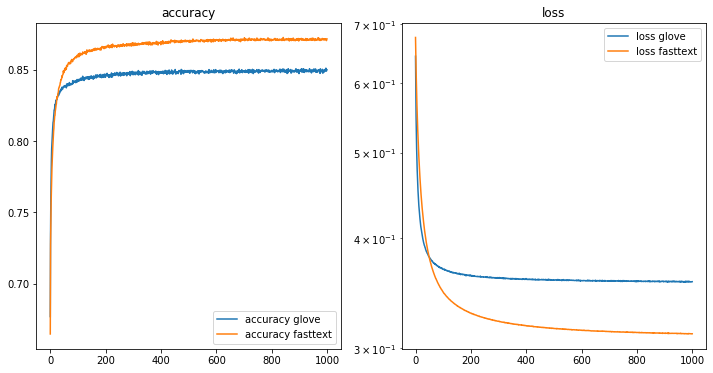

In [33]:
from classifier_word_embeddings import train
model = LogisticRegressionBow(300, 2)#.cuda()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
loss_function = nn.CrossEntropyLoss()
acc,losses=train(model,optimizer,loss_function,train_tensors[-1],train_labels=train_labels,batch_size=50,epochs=1000,accuracy_score=accuracy_score)


preds_train=prediction(model,train_tensors[-1],50)
preds_dev=prediction(model,dev_tensors[-1],50)
preds_dev_b=prediction(model,dev_b_tensors[-1],50)
preds_test=prediction(model,test_tensors[-1],50)
preds_test_b=prediction(model,test_b_tensors[-1],50)
print('accuracy train: ',accuracy_score(preds_train,train_labels))
print('accuracy dev: ',accuracy_score(preds_dev,dev_labels))
print('accuracy dev_b: ',accuracy_score(preds_dev_b,dev_labels_b))



from classifier_word_embeddings import train
model = LogisticRegressionBow(300, 2)#.cuda()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
loss_function = nn.CrossEntropyLoss()
acc_fast,losses_fast=train(model,optimizer,loss_function,train_tensors_fast,train_labels=train_labels,batch_size=50,epochs=1000,accuracy_score=accuracy_score)



preds_train=prediction(model,train_tensors_fast,50)
preds_dev=prediction(model,dev_tensors_fast,50)
preds_dev_b=prediction(model,dev_b_tensors_fast,50)
preds_test=prediction(model,test_tensors_fast,50)
preds_test_b=prediction(model,test_b_tensors_fast,50)
print('accuracy train: ',accuracy_score(preds_train,train_labels))
print('accuracy dev: ',accuracy_score(preds_dev,dev_labels))
print('accuracy dev_b: ',accuracy_score(preds_dev_b,dev_labels_b))


plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('accuracy')
plt.plot(acc,label='accuracy glove')
plt.plot(acc_fast,label='accuracy fasttext')
plt.legend()
plt.subplot(122)
plt.semilogy(losses,label='loss glove')
plt.semilogy(losses_fast,label='loss fasttext')
plt.title('loss')
plt.legend()
plt.show()

In [0]:
preds=[preds_train,preds_dev,preds_test,preds_dev_b,preds_test_b]
result=to_df(preds)
result.to_csv('file2_ff.tsv',index=False,header=False,sep='\t')



0it [00:00, ?it/s]
1it [00:01,  1.12s/it]
2it [00:01,  1.01s/it]
3it [00:05,  1.67s/it]
4it [00:05,  1.22s/it]
5it [00:05,  1.04s/it]


### 3.2 Impact of dimensionality

Train document embeddings from the Section 2.3 with different number of dimensions and plot dependence of classification accuracy from the number of dimensions.

Text(0.5, 0, 'dim')

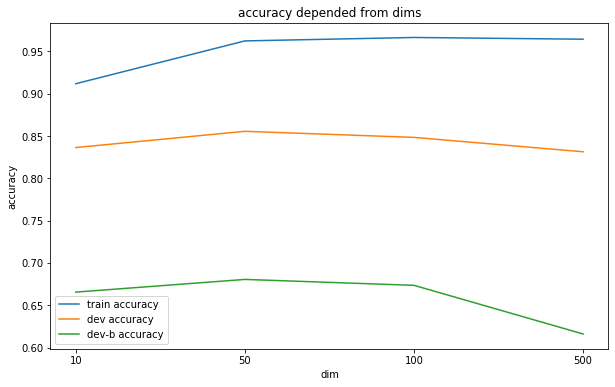

In [0]:
n_dim=[10,50,100,500]
train_accuracy=[]
dev_accuracy=[]
dev_b_accuracy=[]

for comp in n_dim:
  model = Doc2Vec(vector_size=comp, min_count=1, epochs=55)
  model.build_vocab(train_gensim_data)
  model.train(train_gensim_data, total_examples=model.corpus_count, epochs=model.epochs) 
  
  train_vectors=vectors_creature(model,data_train)
  dev_vectors=vectors_creature(model,data_dev)
  dev_b_vectors=vectors_creature(model,data_dev_b)
 
  logreg.fit(train_vectors,train_labels)
  train_accuracy.append(accuracy_score(logreg.predict(train_vectors),train_labels))
  dev_accuracy.append(accuracy_score(logreg.predict(dev_vectors),dev_labels))
  dev_b_accuracy.append(accuracy_score(logreg.predict(dev_b_vectors),dev_labels_b))

plt.figure(figsize=(10,6))
plt.plot(train_accuracy,label='train accuracy')
plt.plot(dev_accuracy,label='dev accuracy')
plt.plot(dev_b_accuracy,label='dev-b accuracy')
plt.title('accuracy depended from dims')
plt.xticks(range(4),(10, 50, 100, 500))
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('dim')